In [14]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostRegressor

from Dataset_Construction import Balance_Ratio 
from Sampling import label_divide
from AdaClassifier import train_set, multiple_set, print_badC, bad_plot, line_chart
from Aging_Score import score1

os.chdir('C:/Users/Darui Yen/OneDrive/桌面/data_after_mid') 
os.getcwd()

'C:\\Users\\Darui Yen\\OneDrive\\桌面\\data_after_mid'

### Load multiple dataset

In [15]:
def multiple_reg(num_set):
    
    data_dict = {}
    for i in range(num_set):
        temp = pd.read_csv(f'dataset_reg_{i}.csv').iloc[:, 1:]
        data_dict[f'set{i}'] = temp.drop(columns = 'GB').rename(columns = {'New_GB': 'GB'})
        print('Dimension of dataset', i, ':', data_dict[f'set{i}'].shape, ' balance ratio:', \
              Balance_Ratio(data_dict[f'set{i}']))
    
    print('\n', num_set, 'reg_datasets are loaded.')
    return data_dict

### Boosting Model

In [16]:
def AdaBoostR(train_x, test_x, train_y, test_y, n_estimator = 100, LR = 0.3):
    
    clf = AdaBoostRegressor(n_estimators = n_estimator, learning_rate = LR, random_state = None)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result

### Recall & Precision for Regressor

In [17]:
def PR_matrix(predict, train_y, prob = 0.5):
    
    Y_new = predict.sort_values(['predict', 'truth'], ascending = [False, True]).reset_index(drop = True)
    Y_new.loc[Y_new['truth'] != 1, 'truth'] = 0
    
    matrix = pd.DataFrame(Y_new.groupby('predict').sum()).rename(columns = {'truth': 'Bad_Count'})
    matrix = matrix.sort_index(ascending = False)
    matrix['All_Count'] = Y_new.groupby('predict').count()
    matrix['Class_Prob'] = matrix.index
    
    matrix['train_OK'] = sum(train_y < 0.5)
    matrix['train_NG'] = len(train_y) - matrix['train_OK'].values[0]
    matrix['Balance Ratio'] = matrix['train_OK'] / matrix['train_NG']
    
    matrix['TP'] = matrix['Bad_Count'].cumsum()
    matrix['FP'] = matrix['All_Count'].cumsum() - matrix['TP']
    matrix['FN'] = matrix['TP'].values[-1] - matrix['TP']
    matrix['TN'] = matrix['FP'].values[-1] - matrix['FP']
    
    matrix['Recall'] = matrix['TP'] / (matrix['TP'] + matrix['FN'])
    matrix['Precision'] = matrix['TP'] / (matrix['TP'] + matrix['FP'])
    matrix['Aging Rate'] = (matrix['TP'] + matrix['FP']) / (matrix['TP'] + matrix['FP'] + matrix['FN'] + matrix['TN'])
    matrix['Efficiency'] = matrix['Recall'] / matrix['Aging Rate']
    matrix['Score'] = score1(matrix['Recall'], matrix['Aging Rate'])
              
    matrix = matrix.drop(columns = ['Bad_Count', 'All_Count']).reset_index(drop = True)
    
    return matrix


def best_threshold(pr_matrix, target, threshold = False):
    
    # input threshold, or find maximum
    if threshold:
        index = pr_matrix[pr_matrix[target] >= threshold].head(1).index.values[0]
    else:
        index = pr_matrix[target].idxmax()
        
    best_data = pr_matrix.loc[index]
    best_thres = best_data['Class_Prob']
    best_data = pd.DataFrame(best_data).T
    print('Best Threshold:', best_thres, '\n')
    print('Recall:', best_data['Recall'].values, ',   Precision:', best_data['Precision'].values, \
          ',   Aging Rate:', best_data['Aging Rate'].values)

    return best_data, best_thres

### Run all dataset

In [18]:
def runall_AdaBoostR(num_set, trainset_x, test_x, trainset_y, test_y, thres_target = 'Recall', threshold = False, 
                     record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        predict = AdaBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(predict, test_x, Bad_Types, threshold = best_thres)
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})
    
    if record_bad:
        return pr_dict, table_set, bad_set
    else:
        return pr_dict, table_set

### Plot all dataset

In [19]:
def AUC(x, y):
    
    area=0
    left=x[0]*y[0]
    right=(1-x[len(x)-1])*y[len(x)-1]
    
    for i in range(1,len(x)):
        wide=x[i]-x[i-1]
        area=area+wide*((y[i-1]+y[i])/2)
    area=left+area+right  
    
    return area


def PR_curve(pr_matrix, best_data, title = 'PR_curve'):
    
    plt.plot(pr_matrix['Recall'], pr_matrix['Precision'], 'b-')
    plt.plot(pr_matrix['Recall'], pr_matrix['Precision'], 'r.')
    plt.plot(best_data['Recall'], best_data['Precision'], 'go', markersize = 10)
    print('Precision, Recall, Aging Rate:', best_data['Precision'].values, best_data['Recall'].values, 
          best_data['Aging Rate'].values)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title}')
    plt.show()
    auc = AUC(pr_matrix['Recall'].values, pr_matrix['Precision'].values)
    print('AUC: ', auc, '\n')
    
    
def multiple_curve(row_num, col_num, pr_dict, table_set, target = 'Aging Rate'):
    
    fig, axs = plt.subplots(row_num, col_num, sharex = False, sharey = False, figsize = (30,15))
    plt.suptitle(f'{target} & Recall Curve of Dataset 0 - 8', y = 0.94, fontsize = 30)
    
    for row in range(row_num):
        for col in range(col_num):
            index = col_num*row + col
            auc = AUC(pr_dict[f'set{index}']['Recall'].values, pr_dict[f'set{index}'][target].values).round(4)
            ar = table_set["Aging Rate"][index].round(3)
            recall = table_set["Recall"][index].round(3)
            precision = table_set["Precision"][index].round(5)

            axs[row, col].plot(pr_dict[f'set{index}']['Recall'], pr_dict[f'set{index}'][target], 'b-')
            axs[row, col].plot(pr_dict[f'set{index}']['Recall'], pr_dict[f'set{index}'][target], 'r.', markersize = 10)
            axs[row, col].plot(table_set['Recall'][index], table_set[target][index], 'go', markersize = 15)
            axs[row, col].set_xlabel('Recall')
            axs[row, col].set_ylabel(target)
            
            if target == 'Aging Rate':
                axs[row, col].set_title(f'dataset {index},   AUC = {auc},   Aging Rate = {ar},   Recall = {recall}, \
                                        Precision = {precision}')
            elif target == 'Precision':
                axs[row, col].set_title(f'dataset {index},       AUC = {auc},       Aging Rate = {ar},       Recall = {recall}')

## Data Processing

In [20]:
###bad types###
bad = pd.read_csv('original_data/Bad_Types.csv').iloc[:, 1:]
Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
print('Total bad types:', len(bad))

###single dataset###
test = pd.read_csv('original_data/TestingSet_0.csv').iloc[:, 2:]
train = pd.read_csv('original_data/TrainingSet_new.csv').iloc[:, 2:]
print('\ntraining data:', train.shape, '\nBalance Ratio:', Balance_Ratio(train))
print('\ntesting data:', test.shape, '\nBalance Ratio:', Balance_Ratio(test))

train_x, train_y, test_x, test_y = label_divide(train, test, 'GB')

###multiple dataset###
'''
data_dict = multiple_set(num_set = 9)
trainset_x, trainset_y = train_set(data_dict, num_set = 9, label = 'GB')
test_x, test_y = label_divide(test, None, 'GB', train_only = True)
'''

data_dict = multiple_reg(num_set = 9)
trainset_x, trainset_y = train_set(data_dict, num_set = 9, label = 'GB')
test_x, test_y = label_divide(test, None, 'GB', train_only = True)

Total bad types: 62

training data: (77138, 83) 
Balance Ratio: 18.17902

testing data: (55903, 83) 
Balance Ratio: 3104.72222
Dimension of dataset 0 : (77138, 83)  balance ratio: 0.87345
Dimension of dataset 1 : (111685, 83)  balance ratio: 0.09108
Dimension of dataset 2 : (111685, 83)  balance ratio: 0.09108
Dimension of dataset 3 : (111685, 83)  balance ratio: 0.09108
Dimension of dataset 4 : (109674, 83)  balance ratio: 0.09609
Dimension of dataset 5 : (32176, 83)  balance ratio: 0.00166
Dimension of dataset 6 : (32176, 83)  balance ratio: 0.00166
Dimension of dataset 7 : (32176, 83)  balance ratio: 0.00166
Dimension of dataset 8 : (30165, 83)  balance ratio: 0.00199

 9 reg_datasets are loaded.

Labels of  9 datasets are divided.


In [21]:
start = time.time()

pr_dict, table_set, bad_set = runall_AdaBoostR(9, trainset_x, test_x, trainset_y, test_y, 
                                               thres_target = 'Recall', threshold = 0.8)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))


 Dataset 0:
Best Threshold: 0.1490645529848639 

Recall: [0.83333333] ,   Precision: [0.00032387] ,   Aging Rate: [0.82848863]
Types of Bad found: [2, 2, 4, 5, 7, 11, 15, 17, 22, 23, 33, 39, 40, 48, 49]
Types of Bad not found: [6, 42, 45]

 Dataset 1:
Best Threshold: 0.18283506030237356 

Recall: [0.83333333] ,   Precision: [0.00030977] ,   Aging Rate: [0.86619681]
Types of Bad found: [2, 2, 4, 5, 7, 11, 15, 17, 22, 33, 39, 40, 42, 48, 49]
Types of Bad not found: [6, 23, 45]

 Dataset 2:
Best Threshold: 0.16174531628491456 

Recall: [0.94444444] ,   Precision: [0.00033337] ,   Aging Rate: [0.91220507]
Types of Bad found: [2, 2, 4, 5, 7, 11, 15, 17, 22, 23, 33, 39, 40, 42, 45, 48, 49]
Types of Bad not found: [6]

 Dataset 3:
Best Threshold: 0.275182849384659 

Recall: [0.83333333] ,   Precision: [0.00030757] ,   Aging Rate: [0.8723861]
Types of Bad found: [2, 2, 4, 5, 7, 11, 15, 17, 22, 23, 33, 39, 40, 48, 49]
Types of Bad not found: [6, 42, 45]

 Dataset 4:
Best Threshold: 0.312078272

C:\Users\Darui Yen\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Darui Yen\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


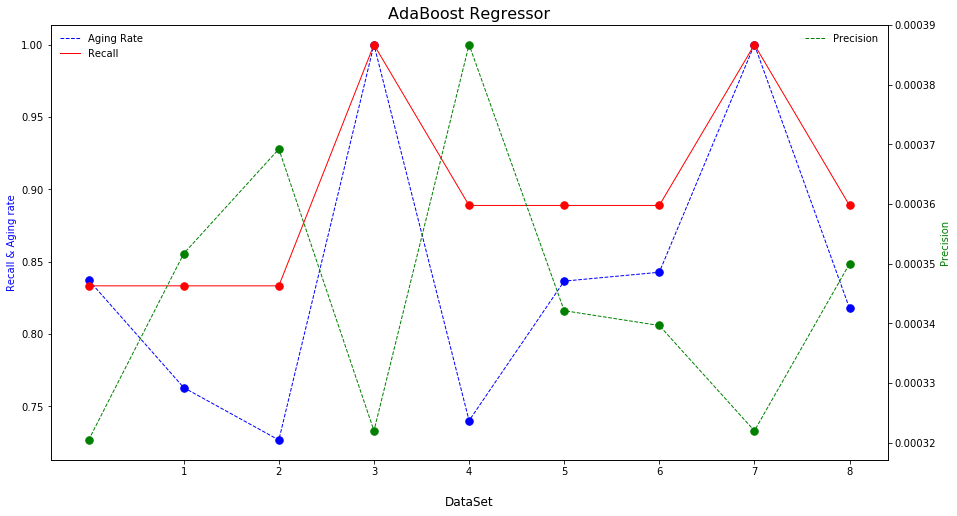

In [9]:
line_chart(table_set, title = 'AdaBoost Regressor')

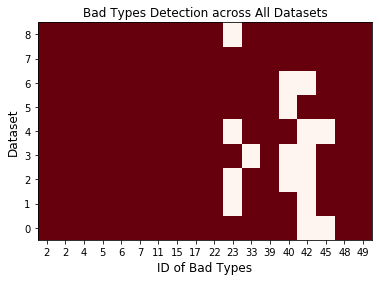

,Bad_Found,Bad_Missed,Detect Ratio
dataset 0,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39,...","[42, 45]",0.888889
dataset 1,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 33, 39, 40,...","[23, 42]",0.888889
dataset 2,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 33, 39, 45,...","[23, 40, 42]",0.833333
dataset 3,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 39, 45,...","[33, 40, 42]",0.833333
dataset 4,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 33, 39, 40,...","[23, 42, 45]",0.833333
dataset 5,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39,...",[40],0.944444
dataset 6,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39,...","[40, 42]",0.888889
dataset 7,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 23, 33, 39,...",[],1.000000
dataset 8,"[2, 2, 4, 5, 6, 7, 11, 15, 17, 22, 33, 39, 40,...",[23],0.944444


In [382]:
bad_plot(bad_set)
bad_set

C:\Users\Darui Yen\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


,Class_Prob,train_OK,train_NG,Balance Ratio,TP,FP,FN,TN,Recall,Precision,Aging Rate,Efficiency,Score
dataset 0,0.061478,73116.0,4022.0,18.179015,15.0,46796.0,3.0,9089.0,0.833333,0.000320,0.837361,0.995190,0.000000
dataset 1,0.153567,73116.0,38569.0,1.895719,15.0,42638.0,3.0,13247.0,0.833333,0.000352,0.762982,1.092205,0.615182
dataset 2,0.144826,73116.0,38569.0,1.895719,15.0,40613.0,3.0,15272.0,0.833333,0.000369,0.726759,1.146644,0.636588
dataset 3,0.100731,73116.0,38569.0,1.895719,18.0,55885.0,0.0,0.0,1.000000,0.000322,1.000000,1.000000,0.000000
dataset 4,0.144149,73116.0,36558.0,2.000000,16.0,41361.0,2.0,14524.0,0.888889,0.000387,0.740157,1.200946,0.701233
dataset 5,0.200183,20110.0,12066.0,1.666667,16.0,46752.0,2.0,9133.0,0.888889,0.000342,0.836592,1.062512,0.643489
dataset 6,0.200828,20110.0,12066.0,1.666667,16.0,47094.0,2.0,8791.0,0.888889,0.000340,0.842710,1.054798,0.640158
dataset 7,0.093211,20110.0,12066.0,1.666667,18.0,55885.0,0.0,0.0,1.000000,0.000322,1.000000,1.000000,0.000000
dataset 8,0.198416,20110.0,10055.0,2.000000,16.0,45702.0,2.0,10183.0,0.888889,0.000350,0.817809,1.086914,0.653944


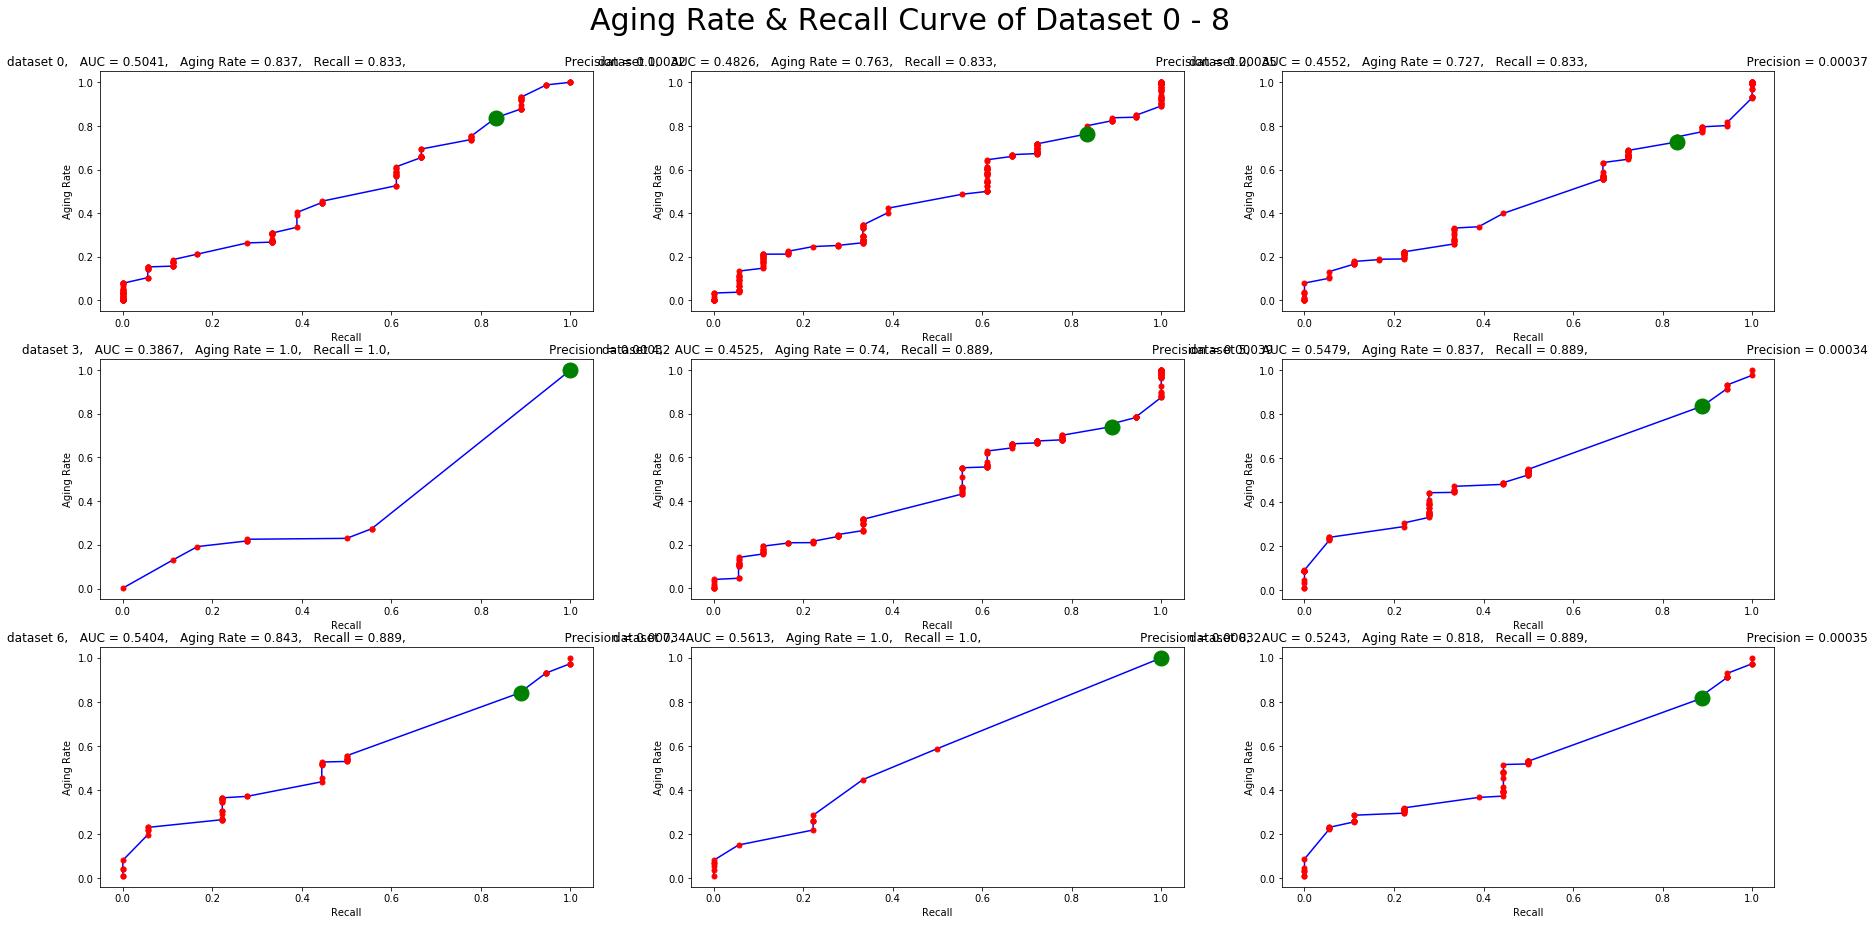

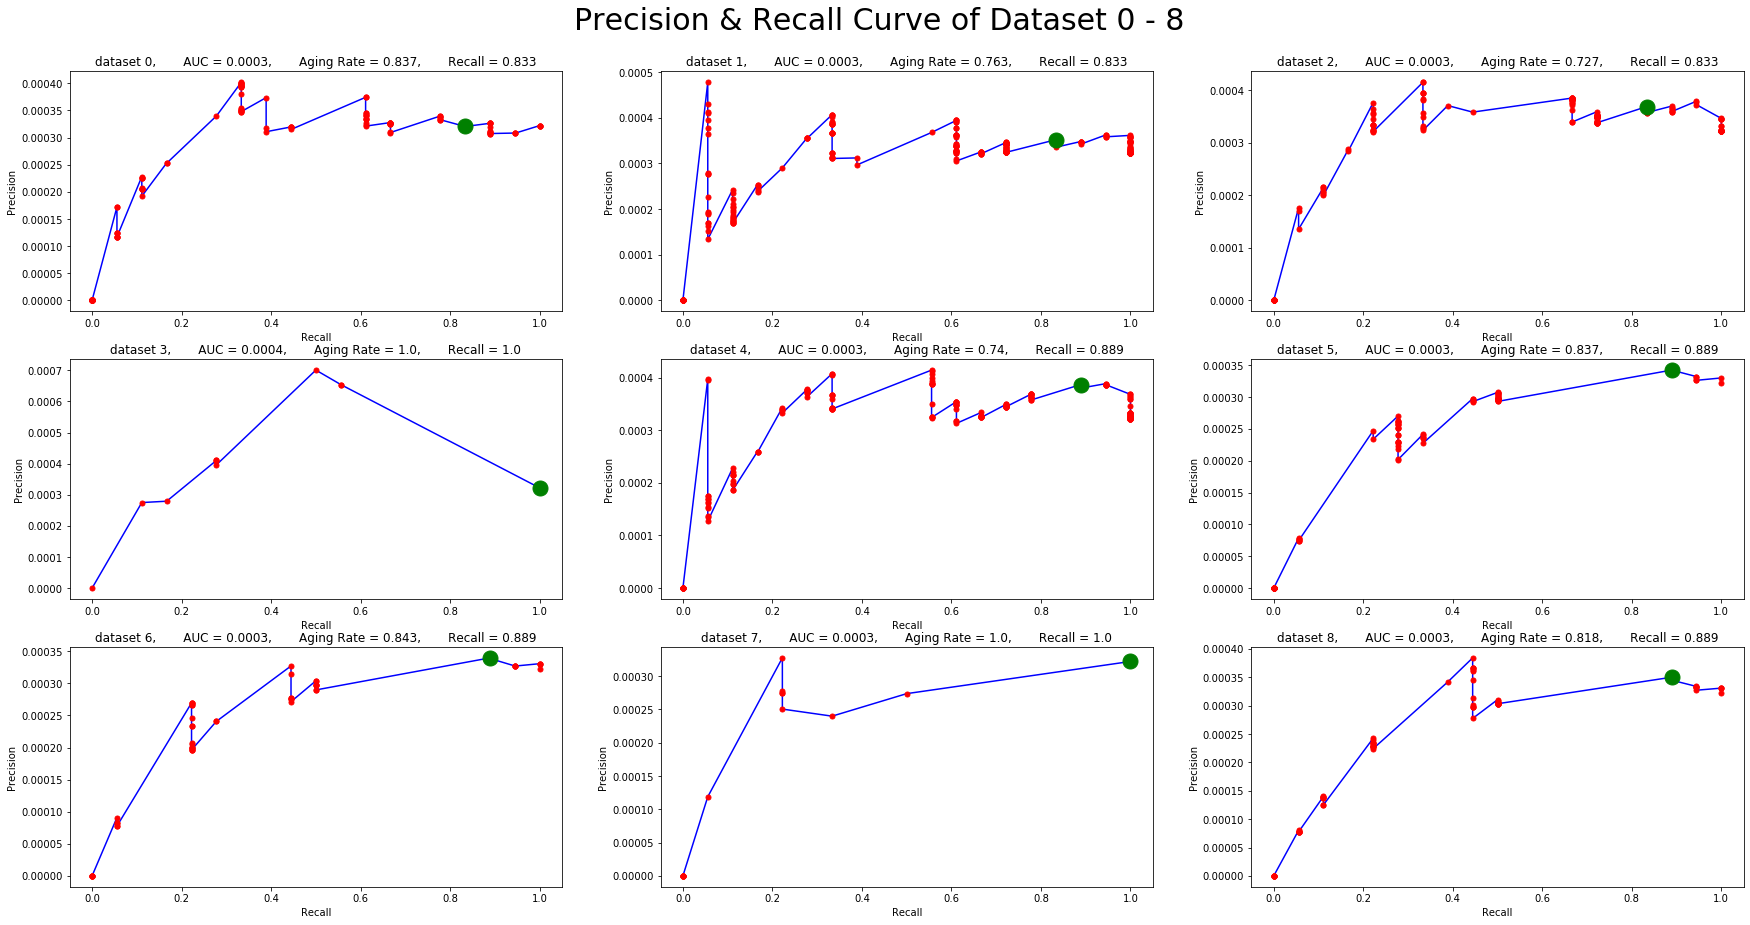

In [13]:
multiple_curve(3, 3, pr_dict, table_set, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_set, target = 'Precision')
table_set